## Time Series Analysis & Sales Forecasting ##

## 1.Import Libraries ##

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import regularizers

## 2.Load Data ##

In [3]:
df = pd.read_csv('train 2.csv')
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


## Data Description ## 

The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
- store_nbr identifies the store at which the products are sold.
- family identifies the type of product sold.
- sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

In [4]:
store_data = pd.read_csv('stores.csv')
store_data.head()


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


## Data Description ## 

Store metadata, including city, state, type, and cluster.
- cluster is a grouping of similar stores.

## 3.1 Data Overview & Cleaning ##

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In our dataset, the data type of the 'Date' column is currently set as 'object'. We will convert it to the 'datetime' type to facilitate date-based analysis. Additionally, the 'id' column does not offer significant value for our analysis, so we will remove it. These steps will enhance the accuracy and cleanliness of our data, making it more suitable for further analysis.

In [6]:
df['date'] = pd.to_datetime(df['date'])
df = df.drop('id', axis=1)
print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   sales        float64       
 4   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 114.5+ MB
None


,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [7]:
df.isnull().sum()

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [8]:
# Check if all records in the 'family' column are uppercase
all_uppercase = df['family'].str.isupper().all()

# Print the result
print("Are all records in the 'family' column uppercase?", all_uppercase)

Are all records in the 'family' column uppercase? True


In [9]:
df.describe()

,date,store_nbr,sales,onpromotion
count,3000888,3.000888e+06,3.000888e+06,3.000888e+06
mean,2015-04-24 08:27:04.703088384,2.750000e+01,3.577757e+02,2.602770e+00
min,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00
25%,2014-02-26 18:00:00,1.400000e+01,0.000000e+00,0.000000e+00
50%,2015-04-24 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00
75%,2016-06-19 06:00:00,4.100000e+01,1.958473e+02,0.000000e+00
max,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02
std,NaN,1.558579e+01,1.101998e+03,1.221888e+01


The minimum and 25th percentile values for sales are both zero, it suggests that a significant portion of the data has zero sales for the specified product family at certain stores and dates.it refers maybe Seasonality or Trends, Out of Stock, Special Events or Holidays causes these zero sales.
The 'onpromotion' column has zeros for the minimum, 25th percentile, and 75th percentile, but the maximum is 741000000, it suggests that promotions for the specified product family at certain stores and dates are relatively uncommon, with most records indicating no promotions.

## 3.2 Data Overview & Cleaning ##

In [10]:
store_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [11]:
store_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [12]:
store_data.describe(include='object')


,city,state,type
count,54,54,54
unique,22,16,5
top,Quito,Pichincha,D
freq,18,19,18


In [13]:
store_data.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [14]:
# Check if all values in the 'city' column have the correct format
city_correct_format = store_data['city'].str.istitle().all()

# Check if all values in the 'state' column have the correct format
state_correct_format = store_data['state'].str.istitle().all()

# Print the results
print("Are all values in the 'city' column in the correct format?", city_correct_format)
print("Are all values in the 'state' column in the correct format?", state_correct_format)


Are all values in the 'city' column in the correct format? True
Are all values in the 'state' column in the correct format? False


In [15]:
# Convert 'state' column values to the correct format (first letter uppercase, rest lowercase)
store_data['state'] = store_data['state'].str.title()


In [16]:
# Check if all values in the 'state' column have the correct format
state_correct_format = store_data['state'].str.istitle().all()
print("Are all values in the 'state' column in the correct format?", state_correct_format)


Are all values in the 'state' column in the correct format? True


## 4. Data Exploration ##

In [17]:
# We will check the Date range in our dataset
first_date =  df['date'].min() 
last_date  =  df['date'].max()
print(f"Date range in our dataset:from {first_date} to {last_date}")

Date range in our dataset:from 2013-01-01 00:00:00 to 2017-08-15 00:00:00


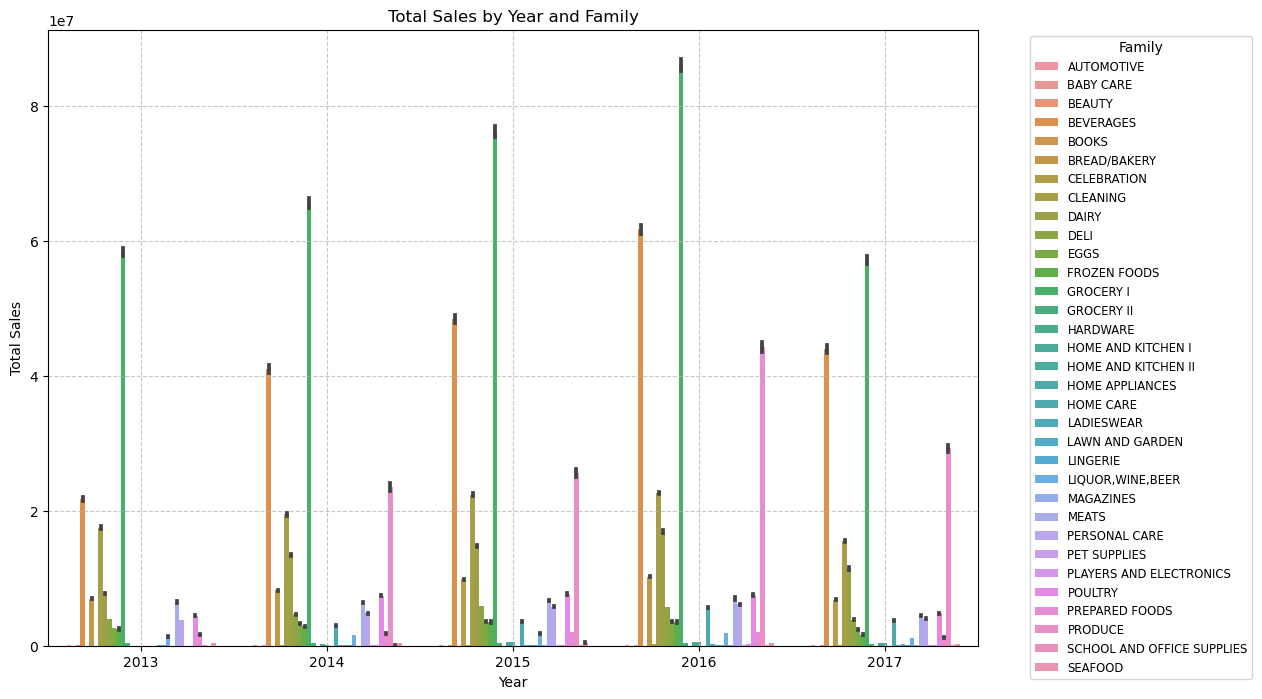

In [23]:
# we will visualize how the sales changed by each year and family type

# Extract Year
df['year'] = df['date'].dt.year

# Plotting using barplot
plt.figure(figsize=(12, 8))  
sns.barplot(data=df, x='year', y='sales', hue='family', estimator=sum)
plt.title('Total Sales by Year and Family')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.legend(title='Family', loc='upper left', fontsize='small')  
plt.grid(True, linestyle='--', alpha=0.7) 
plt.legend(title='Family', loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small') 
plt.show()




From the plot above, we can observe that grocery products have consistently sold well over the past years. Beverages and poultry also showed strong sales from 2014 to 2017. An interesting pattern emerges in the third quarter of each year between 2013 and 2017, where almost no products were sold. Additionally, the first and second months of each year also experienced lower sales, indicating these periods were less favorable for business.

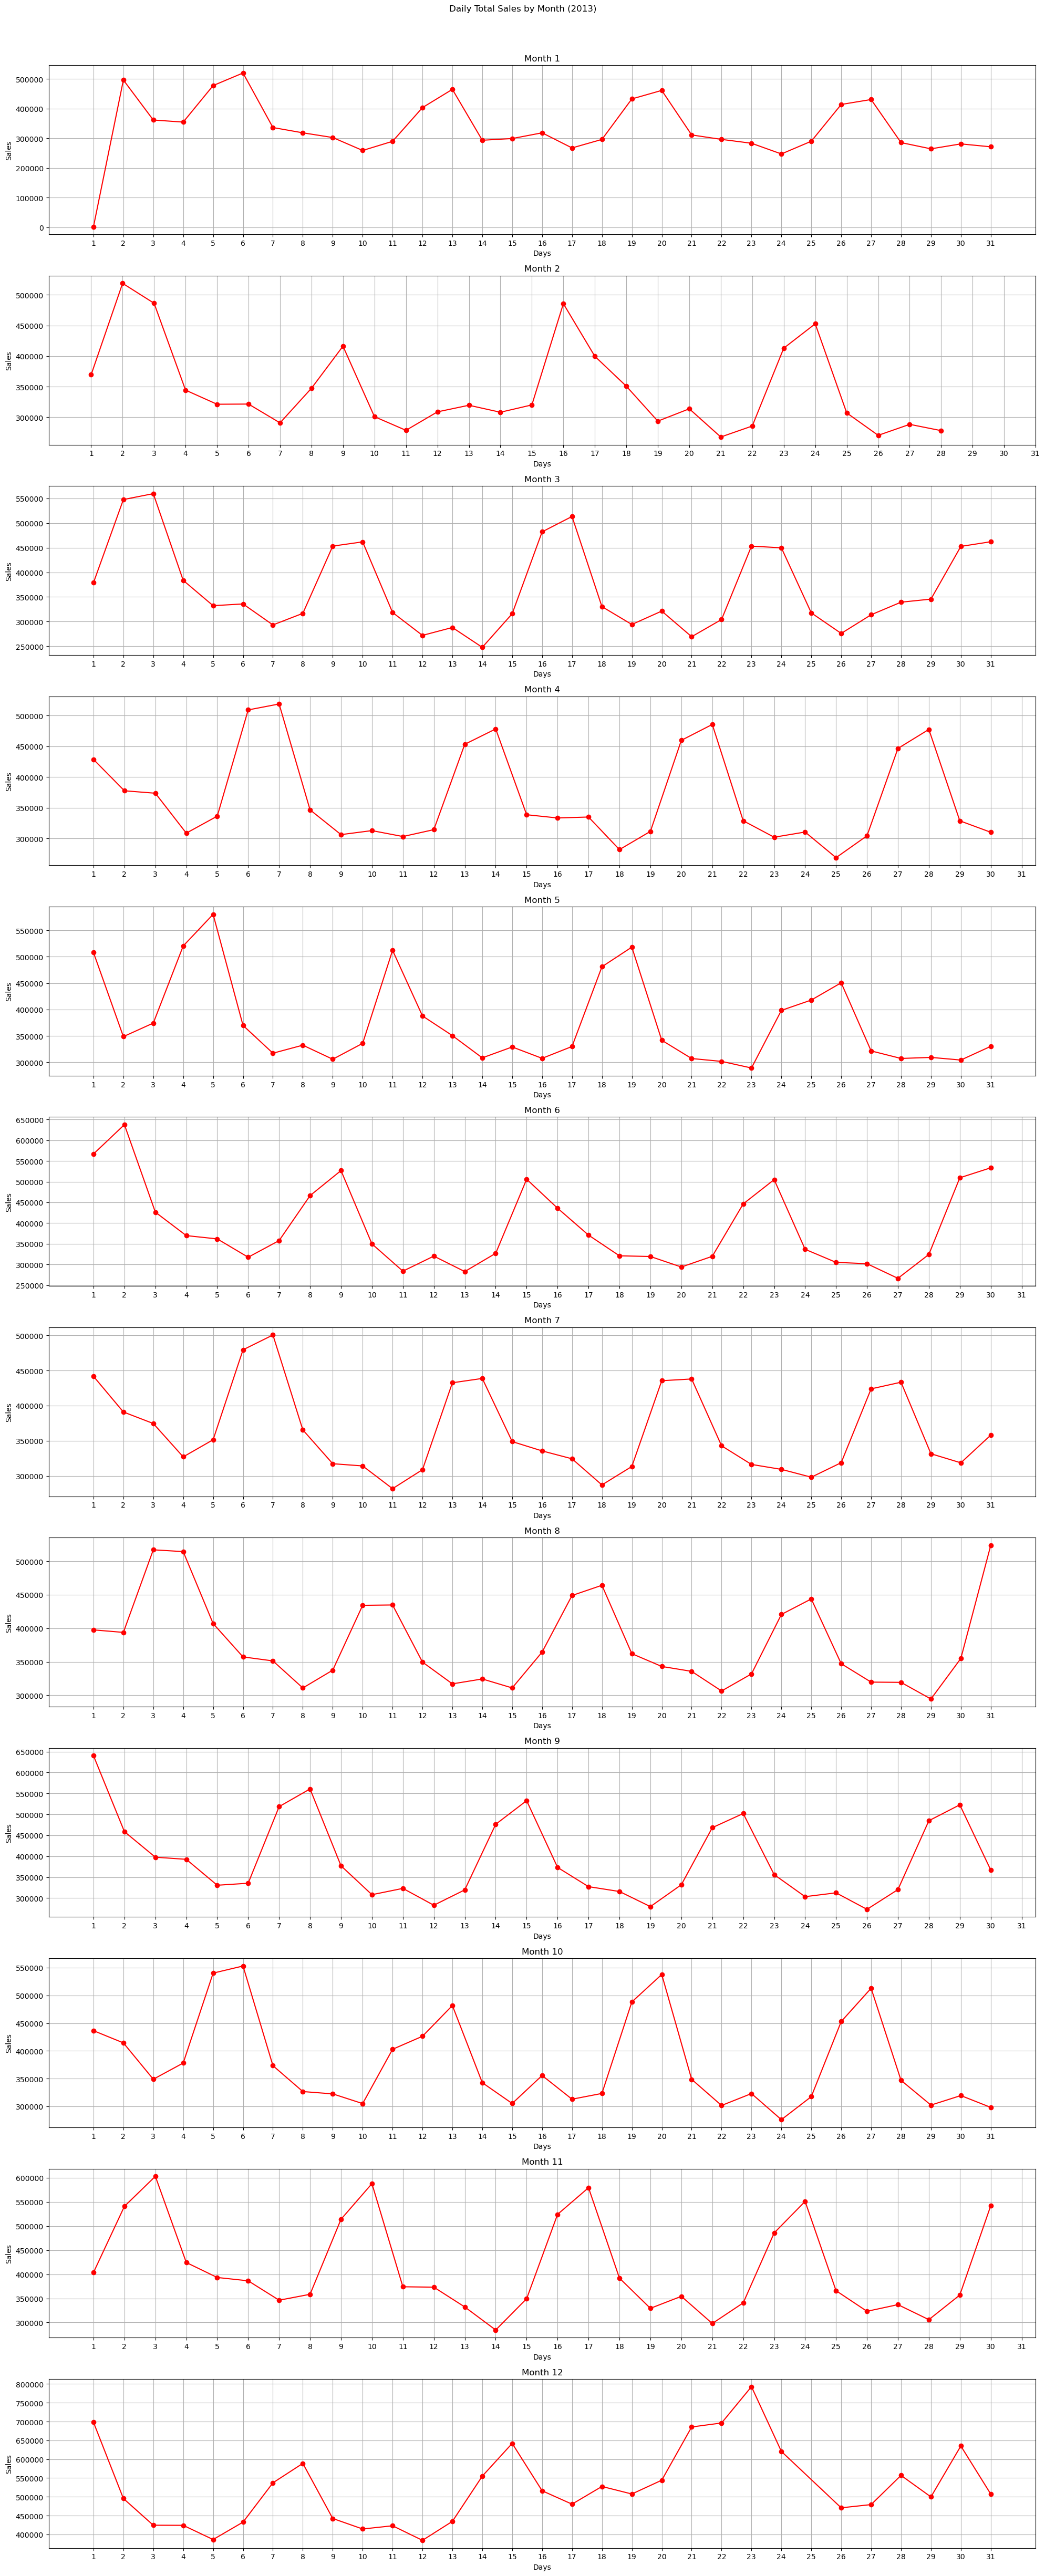

In [24]:
# Calculate total sales by date
total_sales = df[['date', 'sales']].groupby('date').sum()

# Create subplots
fig, ax = plt.subplots(12, 1, figsize=(20, 50))

# Plot total sales for each month
for i, month in enumerate(range(1, 13)):
    current_month_total_sales = total_sales.loc[(total_sales.index.year == 2013) & (total_sales.index.month == month)]
    ax[i].plot(current_month_total_sales.index.day, current_month_total_sales['sales'], color='red', marker='o')
    ax[i].set_title(f'Month {month}')
    ax[i].set_ylabel('Sales')
    ax[i].set_xlabel('Days')
    ax[i].set_xticks(range(1, 32))  
    ax[i].set_xticklabels(range(1, 32))  
    ax[i].grid(True)  # Add grid

# Add a main title
plt.suptitle('Daily Total Sales by Month (2013)')
plt.tight_layout(rect=[0, 0, 1, 0.97])  
plt.show()



From the daily sales plots, we can see that sales peaked on the 6th, 7th, 14th, 15th, 21st, and 28th days of the month. This pattern suggests that people tend to shop more actively on weekends.

## 5.Data Preprocessing ##

Our time series data has 33 * 54 = 1782 observations for same day(for each combination of family and store_nbr).
Time series require each observation to represent a measure at a different period of time. in order to solve this problem, 
we will reshape our data and  make 1782 measure for each row. This way, each observation will represent a time period, and each measure will represent sales for a combination of the two categorical features. As if we are splitting our time serie to a multivariate time serie.

In [ ]:
def ts_pivot(ts):
    onpromotion = ts[['date', 'onpromotion']].groupby('date').mean()
    sales = ts.pivot_table(index='date', columns=['store_nbr', 'family'], values='sales')
    sales.columns = ['_'.join(str(col) for col in column) for column in sales.columns.values]
    return sales.join(onpromotion, how='inner')

In [21]:
print(f'Old shape of the training dataset: {df.shape}')
df = ts_pivot(df)
df = df.sort_index()
print(f'New shape of the training dataset: {df.shape}')
df.head()

Old shape of the training dataset: (3000888, 6)
New shape of the training dataset: (1684, 1783)


,1_AUTOMOTIVE,1_BABY CARE,1_BEAUTY,1_BEVERAGES,1_BOOKS,1_BREAD/BAKERY,1_CELEBRATION,1_CLEANING,1_DAIRY,1_DELI,...,54_MEATS,54_PERSONAL CARE,54_PET SUPPLIES,54_PLAYERS AND ELECTRONICS,54_POULTRY,54_PREPARED FOODS,54_PRODUCE,54_SCHOOL AND OFFICE SUPPLIES,54_SEAFOOD,onpromotion
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,...,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
2013-01-02,2.0,0.0,2.0,1091.0,0.0,470.652,0.0,1060.0,579.0,164.069,...,73.771,228.0,0.0,0.0,15.514,61.0,0.0,0.0,3.0,0.0
2013-01-03,3.0,0.0,0.0,919.0,0.0,310.655,0.0,836.0,453.0,151.582,...,50.257,156.0,0.0,0.0,4.313,1.0,0.0,0.0,2.0,0.0
2013-01-04,3.0,0.0,3.0,953.0,0.0,198.366,0.0,827.0,460.0,131.411,...,40.223,146.0,0.0,0.0,26.743,38.0,0.0,0.0,2.0,0.0
2013-01-05,5.0,0.0,3.0,1160.0,0.0,301.057,0.0,811.0,464.0,118.613,...,43.431,205.0,0.0,0.0,31.118,32.0,0.0,0.0,1.0,0.0


In [ ]:
# we will transform pandas dataframe to a structure that is suitable for keras.
data_matrix = df.values
data_matrix[:5, :]

In [24]:
# we split the data train and validation set
num_val_samples = 30
num_test_samples = 30
num_train_samples = len(df) - num_val_samples - num_test_samples

sequence_length = 7 # we use the past 7 days of sales data for forecasting current day's sales

train = data_matrix[:num_train_samples, :]
val = data_matrix[num_train_samples - sequence_length:num_train_samples + num_val_samples, :]
test = data_matrix[num_train_samples + num_val_samples - sequence_length:, :]

print("num_train_samples:", train.shape)
print("num_val_samples:", val.shape)
print("num_test_samples:", test.shape)

num_train_samples: (1624, 1783)
num_val_samples: (37, 1783)
num_test_samples: (37, 1783)


In [28]:
train = keras.utils.timeseries_dataset_from_array(
    data= train,
    targets= train[sequence_length:, :-1],
    sequence_length=sequence_length,
    batch_size=32
)

val = keras.utils.timeseries_dataset_from_array(
    data= val,
    targets= val[sequence_length:, :-1],
    sequence_length=sequence_length,
    batch_size=16
)

test = keras.utils.timeseries_dataset_from_array(
    data= test,
    targets= test[sequence_length:, :-1],
    sequence_length=sequence_length,
    batch_size=16
)

## 6.Train Neural Network Model ##

In [29]:
# we will try first with  Neural Networks
inputs = keras.Input(shape=(sequence_length, df.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(df.shape[-1] - 1)(x)
model = keras.Model(inputs, outputs)

# compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [31]:
model_checkpoint = callbacks.ModelCheckpoint(
    'classic_nn.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# train model
history = model.fit(
    train,
    epochs=200,
    validation_data=val,
    callbacks=[model_checkpoint]
)

Epoch 1/200
49/51 [===========================>..] - ETA: 0s - loss: 382807.3438 - mae: 233.0653
Epoch 1: val_loss improved from inf to 153605.60938, saving model to classic_nn.h5
51/51 [==============================] - 2s 15ms/step - loss: 377465.4688 - mae: 231.3275 - val_loss: 153605.6094 - val_mae: 148.1950
Epoch 2/200
 7/51 [===>..........................] - ETA: 0s - loss: 220348.8906 - mae: 173.9402

/Users/nazira/miniconda3/envs/metrica/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/51 [===========================>..] - ETA: 0s - loss: 223996.6875 - mae: 173.3736
Epoch 2: val_loss did not improve from 153605.60938
51/51 [==============================] - 1s 11ms/step - loss: 223533.0625 - mae: 172.6678 - val_loss: 159276.7969 - val_mae: 142.0645
Epoch 3/200
49/51 [===========================>..] - ETA: 0s - loss: 199553.9219 - mae: 147.9134
Epoch 3: val_loss improved from 153605.60938 to 153437.64062, saving model to classic_nn.h5
51/51 [==============================] - 1s 11ms/step - loss: 199223.2969 - mae: 147.4828 - val_loss: 153437.6406 - val_mae: 127.0034
Epoch 4/200
49/51 [===========================>..] - ETA: 0s - loss: 201059.0000 - mae: 139.5984
Epoch 4: val_loss improved from 153437.64062 to 153203.00000, saving model to classic_nn.h5
51/51 [==============================] - 1s 12ms/step - loss: 200669.2031 - mae: 139.3072 - val_loss: 153203.0000 - val_mae: 124.5815
Epoch 5/200
46/51 [==========================>...] - ETA: 0s - loss: 195187.7812 - 

In [32]:
model = keras.models.load_model("classic_nn.h5")
print(f"Test MAE: {model.evaluate(test)[1]:.2f}")

2/2 [==============================] - 0s 4ms/step - loss: 82481.3828 - mae: 91.1813
Test MAE: 91.18


In [33]:
def plot_history(history):
    loss = history.history["mae"]
    val_loss = history.history["val_mae"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, "bo", label="Training MAE")
    plt.plot(epochs, val_loss, "b", label="Validation MAE")
    plt.title("Training and validation MAE")
    plt.legend()
    plt.show()

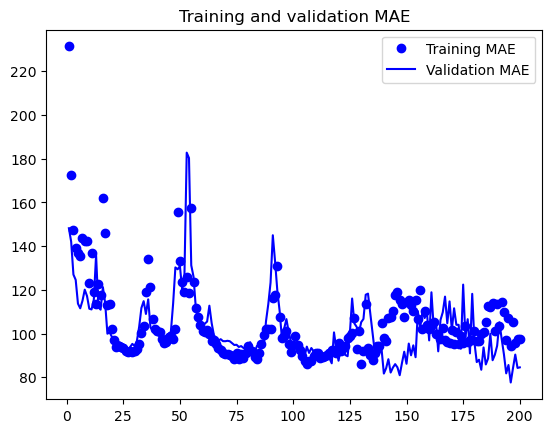

In [34]:
plot_history(history)

When we look at the plot above, we see that the model didn't actually overfit on the training data. The validation and training mae are very close from each others.
We see that there is no need to train the model on more epochs, because the evaluation metric seems to keep going up and down the more the model trains.

## 7.Recurrent Neural Netowrks (RNN) ##

In [35]:
inputs = keras.Input(shape=(sequence_length, df.shape[-1]))
x = layers.SimpleRNN(200, return_sequences=True)(inputs)
x = layers.SimpleRNN(200, return_sequences=True)(x)
x = layers.SimpleRNN(200, return_sequences=True)(x)
x = layers.SimpleRNN(200, return_sequences=True)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(df.shape[-1] - 1)(x)
model = keras.Model(inputs, outputs)
print(model.summary())

# compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# train model
early_stopping = callbacks.EarlyStopping(
    monitor='val_mae',
    patience=100,
    restore_best_weights=True
)
model_checkpoint = callbacks.ModelCheckpoint(
    'rnn.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# train model
history = model.fit(
    train,
    epochs=500,
    validation_data=val,
    callbacks=[early_stopping, model_checkpoint]
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7, 1783)]         0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 7, 200)            396800    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 7, 200)            80200     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 7, 200)            80200     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 7, 200)            80200     
                                                                 
 flatten_1 (Flatten)         (None, 1400)              0         
                                                                 
 dense_6 (Dense)             (None, 1782)              2496

In [36]:
model = keras.models.load_model("rnn.h5")
print(f"Test MAE: {model.evaluate(test)[1]:.2f}")

2/2 [==============================] - 0s 8ms/step - loss: 277971.0312 - mae: 145.9557
Test MAE: 145.96


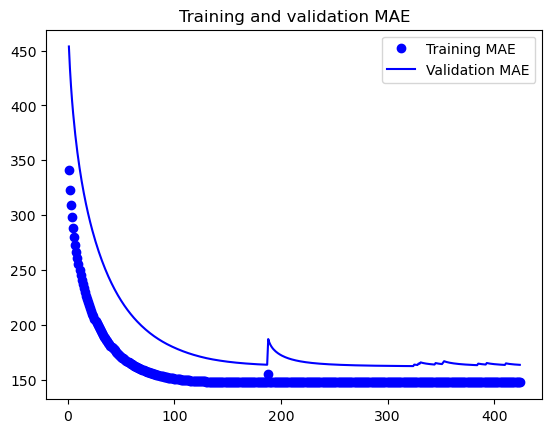

In [37]:
plot_history(history)

From the plot above, it is clear that Our RNN model starts overfitting.

## 8.Gated Recurrent Unit (GRU) ##

In [38]:
inputs = keras.Input(shape=(sequence_length, df.shape[-1]))
x = layers.GRU(200, return_sequences=True)(inputs)
x = layers.GRU(200, return_sequences=True)(x)
x = layers.GRU(200, return_sequences=True)(x)
x = layers.GRU(200, return_sequences=True)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(df.shape[-1] - 1)(x)
model = keras.Model(inputs, outputs)
print(model.summary())

# compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# train model
early_stopping = callbacks.EarlyStopping(
    monitor='val_mae',
    patience=100,
    restore_best_weights=True
)
model_checkpoint = callbacks.ModelCheckpoint(
    'gru.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# train model
history = model.fit(
    train,
    epochs=500,
    validation_data=val,
    callbacks=[early_stopping, model_checkpoint]
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 7, 1783)]         0         
                                                                 
 gru (GRU)                   (None, 7, 200)            1191000   
                                                                 
 gru_1 (GRU)                 (None, 7, 200)            241200    
                                                                 
 gru_2 (GRU)                 (None, 7, 200)            241200    
                                                                 
 gru_3 (GRU)                 (None, 7, 200)            241200    
                                                                 
 flatten_2 (Flatten)         (None, 1400)              0         
                                                                 
 dense_7 (Dense)             (None, 1782)              2496

In [39]:
model = keras.models.load_model("gru.h5")
print(f"Test MAE: {model.evaluate(test)[1]:.2f}")

2/2 [==============================] - 2s 14ms/step - loss: 275198.4688 - mae: 145.3715
Test MAE: 145.37


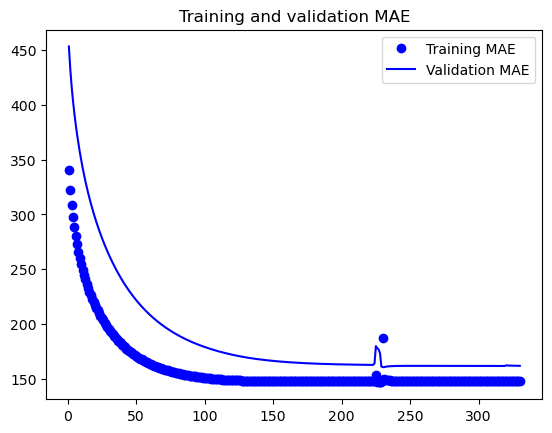

In [40]:
plot_history(history)

This plot is similar to what we might expect from an RNN, indicating that our dataset does not require such a complex model. 

## 9. Evaluate Predictions ##

In [41]:
model = keras.models.load_model("classic_nn.h5")
model.summary()
print(f"Test MAE: {model.evaluate(test)[1]:.2f}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 1783)]         0         
                                                                 
 flatten (Flatten)           (None, 12481)             0         
                                                                 
 dense (Dense)               (None, 64)                798848    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 64)                4160  

In [42]:
predictions = model.predict(
    keras.utils.timeseries_dataset_from_array(
        data= data_matrix,
        targets= data_matrix[sequence_length:, :-1],
        sequence_length=sequence_length
    )
)
print(type(predictions))
print(f"Our predictions matrix is of shape: {predictions.shape}")
print(f"The original dataset is of shape: {data_matrix.shape}")

14/14 [==============================] - 0s 12ms/step
<class 'numpy.ndarray'>
Our predictions matrix is of shape: (1677, 1782)
The original dataset is of shape: (1684, 1783)


In [43]:
predictions_df = pd.DataFrame(predictions, columns=df.columns[:-1], index=df[7:].index)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


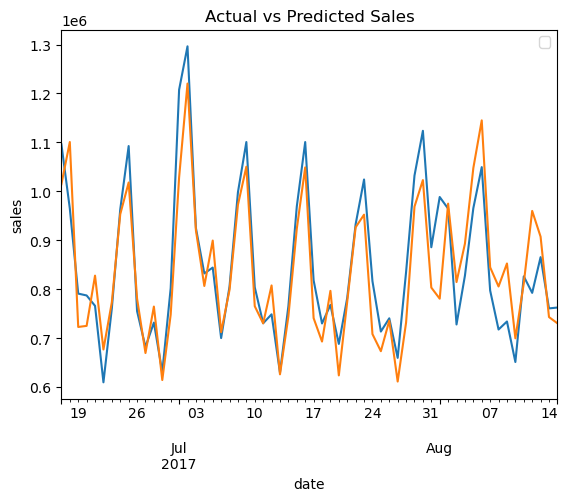

In [44]:
last_n_days = 60
df[-last_n_days:].sum(axis=1).plot(legend='Actual')
predictions_df[-last_n_days:].sum(axis=1).plot(legend='Predicted')
plt.title("Actual vs Predicted Sales")
plt.ylabel("sales")
plt.legend()
plt.show()

Conclusion:
The simple neural network model did a very great job at estimating sales values, with an 91  MAE, even with a very simple architecture, the model didn't overfit the training data, and when plotting the results, we can see that the results are actually reliable.
Sequence models, such as RNN and GRU, didn't seem to be have well with our dataset (145  MAE with a very complex model), that's why we didn't bother to go with the more advanced LSTM architecture.It might be possible to achieve even more accurate results, if we manage to increase the window size from 7 to maybe 28 days, and having a deeper network model. We can also try to include more features, from the additional datasets.